# Le Sujet
"On souhaite déterminer une liste de lignes de bus permettant de desservir un maximum des listes de trajets décrits dans le fichier "OD.csv". Quel est le nombre minimal de ligne de bus pouvant desservir les requêtes ? Sous quelles conditions ?"

J'ai traité ce sujet en Python

# Le dataset

Le dataset est un fichier csv avec 4 colonnes et 636 lignes.    
Les 636 lignes correspondent à 636 trajets que l'on souhaite faire réaliser à des lignes de bus.  
Chaque ligne contient à deux couples de points : un pour le début du trajet et l'autre pour la fin du trajet.  
Chacun des points est représenté par un couple Longitude / Latitude.


In [53]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import math
import random

In [54]:
coord_geo_np = np.loadtxt('OD_sample.csv',delimiter=";")

In [55]:
coord_geo_df = pd.read_csv("OD_sample.csv",header=None,delimiter=";",names=['Long1','Lat1','Long2','Lat2'])

In [56]:
coord_geo_df.shape

(636, 4)

In [57]:
coord_geo_df.head()

,Long1,Lat1,Long2,Lat2
0,2.397652,48.892263,2.373690,48.889394
1,2.382544,48.860732,2.345949,48.883294
2,2.325495,48.845952,2.308557,48.866808
3,2.349616,48.896600,2.299033,48.908707
4,2.406138,48.856142,2.332053,48.829769


Transformer ce dataset en fichier kml permet de visualiser les points dans Google Earth par exemple pour voir la zone géographique en question avec les liens entre les débuts et fins de trajets à prendre en compte.

Il est donc question de la ville de Paris et d'une partie de la petite couronne. Il est intéressant de remarquer qu'il semble y avoir une direction privilégiée Est-Ouest : voir fichier joint "bus.jpg"

Pour confirmer cela je vais transformer les données vers un système de coordonnées orthonormé (Lambert 93 ). Cela va permettre de calculer des distances. J'ai utilisé pour cela la librairie geopandas

In [58]:
gdf1 = gpd.GeoDataFrame(geometry=gpd.points_from_xy(coord_geo_df.Lat1, coord_geo_df.Long1))
gdf1.crs = 'epsg:4326'
gdf1 = gdf1.to_crs("EPSG:3395")
gdf2 = gpd.GeoDataFrame(geometry=gpd.points_from_xy(coord_geo_df.Lat2, coord_geo_df.Long2))
gdf2.crs = 'epsg:4326'
gdf2 = gdf2.to_crs("EPSG:3395")

In [59]:
gdf1

,geometry
0,POINT (5442661.767 265197.070)
1,POINT (5439151.775 263525.040)
2,POINT (5437506.525 257211.538)
3,POINT (5443144.619 259880.894)
4,POINT (5438640.798 266136.200)
...,...
631,POINT (5440149.339 260831.479)
632,POINT (5437013.979 253057.974)
633,POINT (5430230.982 256015.921)
634,POINT (5434304.183 253667.207)


Il est maintenant possible de manipuler ces fichiers dans un numpy array pour plus de simplicité. J'ai gardé pour ce tableau numpy la même structure que la structure du fichier initial

In [60]:
gdf_np = np.zeros((coord_geo_df.shape[0],4))
gdf_np_sc = np.zeros((coord_geo_df.shape[0],4))
for i in range(coord_geo_df.shape[0]):
    gdf_np[i,1]=gdf1.iloc[i,0].xy[0][0]
    gdf_np[i,0]=gdf1.iloc[i,0].xy[1][0]
    gdf_np[i,3]=gdf2.iloc[i,0].xy[0][0]
    gdf_np[i,2]=gdf2.iloc[i,0].xy[1][0]
 

In [61]:
gdf_np.shape

(636, 4)

Les points de départ et d'arrivée dans 2 couleurs différentes

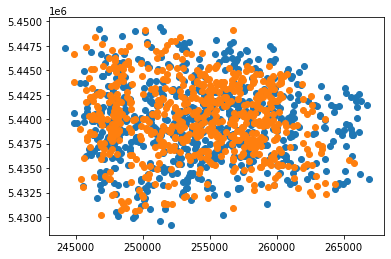

In [62]:
plt.scatter(gdf_np[:,0],gdf_np[:,1])
plt.scatter(gdf_np[:,2],gdf_np[:,3])
plt.show()

Je vais normaliser mon tableau pour avoir un repère centré avec des données en X entre -1 et 1

In [63]:
max_gdf=gdf_np.max(axis=0)
min_gdf=gdf_np.min(axis=0)
max_lon=max(max_gdf[0],max_gdf[2])
min_lon=min(min_gdf[0],min_gdf[2])
max_lat=max(max_gdf[1],max_gdf[3])
min_lat=min(min_gdf[1],min_gdf[3])
delta_lon=max_lon-min_lon
delta_lat=max_lat-min_lat
delta = max(delta_lon,delta_lat)

In [64]:
gdf_np_sc[:,0] = (gdf_np[:,0]-(delta_lon)/2-min_lon)/(delta)*2
gdf_np_sc[:,2] = (gdf_np[:,2]-(delta_lon)/2-min_lon)/(delta)*2

In [65]:
gdf_np_sc[:,1]=(gdf_np[:,1]-(delta_lat)/2-min_lat)/(delta)*2
gdf_np_sc[:,3]=(gdf_np[:,3]-(delta_lat)/2-min_lat)/(delta)*2

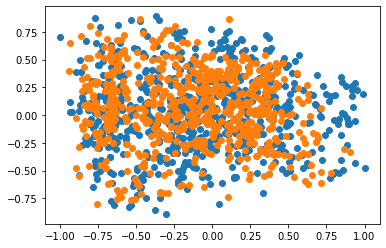

In [66]:
plt.scatter(gdf_np_sc[:,0],gdf_np_sc[:,1])
plt.scatter(gdf_np_sc[:,2],gdf_np_sc[:,3])
plt.show()

Je m'intéresse maintenant à la répartition des données


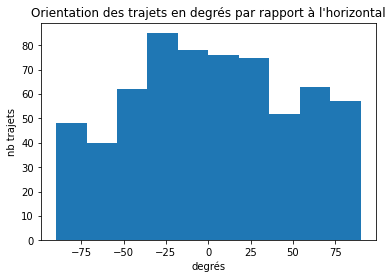

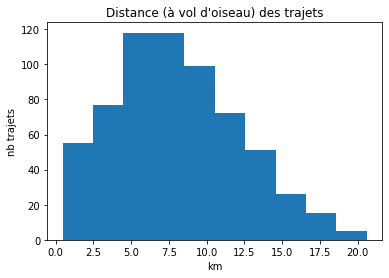

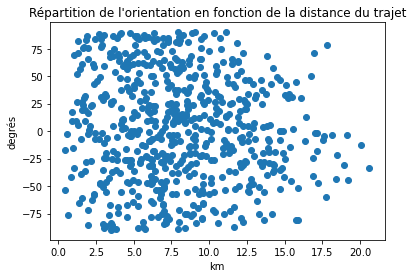

In [67]:
import warnings
warnings.filterwarnings('ignore')
orientation = np.arccos((gdf_np_sc[:,2]-gdf_np_sc[:,0])/np.sqrt((gdf_np_sc[:,2]-gdf_np_sc[:,0])**2+(gdf_np_sc[:,3]-gdf_np_sc[:,1])**2))
orientation = orientation / math.pi *180
plt.hist((orientation+90)%180-90)
plt.xlabel('degrés')
plt.ylabel('nb trajets')
plt.title("Orientation des trajets en degrés par rapport à l'horizontal")
plt.show()
size_travel = np.sqrt((gdf_np_sc[:,3]-gdf_np_sc[:,1])**2+(gdf_np_sc[:,2]-gdf_np_sc[:,0])**2)
plt.hist(size_travel*delta/1000/2)
plt.xlabel('km')
plt.ylabel('nb trajets')
plt.title("Distance (à vol d'oiseau) des trajets")
plt.show()
plt.scatter(size_travel*delta/1000/2,(orientation+90)%180-90)
plt.xlabel('km')
plt.ylabel('degrés')
plt.title("Répartition de l'orientation en fonction de la distance du trajet")
plt.show()

**Ces différents graphs montrent une prédominance des trajets est-ouest et indiquent que ces trajets sont de plus grande distance**

# Cadre de la recherche et simplifications

Une première simplification consiste à ne travailler que sur des distances euclidiennes et non sur des distances réelles (intégrant le plan de circulation). Cela peut se justifier par le maillage important et relativement régulier des rues en région parisienne.

Etant donné les données en ma possession, j'ai exploré deux axes de recherche :

1) le problème s'approche du problème du Traveller Salesman Problem dans lequel il faut trouver le plus court chemin parcourant une liste de points. Mais il s'en éloigne pour deux raisons principales :
* il y a ici plusieurs moyens de transport et non un seul. Des articles et algorithmes traitent également ce problème sous le nom de Vehicule Routing Problem
* une contrainte supplémentaire oblige à passer par les deux points des trajets sélectionnés

Malgré mes recherches et réflexions je n'ai pas aboutit à quelque chose d'intéressant en suivant cette voie.

2) J'ai donc suivi une autre voie qui consiste à traiter les données pour me ramener au Traveller Salesman Problem :
* j'ai cherché une méthode pour décomposer mon problème en plusieurs TSP, c'est à dire de créer plusieurs ensembles de points "homogènes" sur lesquels appliquer le TSP.




# Classification en groupes homogènes de trajets

Mon idée consiste à réaliser une classification non supervisée des trajets en groupes "homogènes" pour pouvoir dans un second temps appliquer la résolution d'un TSP  à chacun de ces groupes.

Pour cela je me suis inspiré de l'algorithme K-means en l'adaptant à ce problème.

Je suis parti de l'hypothèse (très) simplificatrice que chacun des trajets de bus serait une droite traversant l'univers du problème (c'est le cas pour beaucoup de trajets du dataset).

Mon algorithme est donc le suivant :

1) initialiser l'algorithme avec k droites choisies aléatoirement dans le périmètre du projet ( = k lignes de bus)  
2) grouper les couples de points du dataset en k groupes. Chaque couple de point étant rattaché à la droite de laquelle il est le plus proche (la distance utilisée est la somme des distance de chacun des deux points à la droite)  
3) calculer pour chacun des groupes de point la droite de régression linéaire minimisant la distance à chacun des points.  
4) recommencer en 2 avec les nouvelles droites définies.  

En 2) le calcul (Loss) de la somme des distances de chaque point à sa droite la plus proche permet de voir la convergence de l'algorithme.

En pratique l'algorithme converge vite (j'ai choisi 10 itérations par sécurité) et j'ai décidé de rejouer l'exercice 10 fois (et de garder le meilleur résultat) pour prendre en compte l'aspect aléatoire des droites initiales.

J'ai répété l'opération en augmentant progressivement le nombre de bus (voir ci-dessous l'évolution du "Loss" en fonction du nombre de lignes de bus).

Comme on peut s'y attendre plus il y a de droites plus la distance globale à ces droites diminue.

In [68]:
def dist_point_line(a,b,x,y):
    """ 
    distance d'un point à une droite 
    """
    return abs(y-a*x-b)/math.sqrt(1+a**2)

def dist_trajet_line(a,b,x1,y1,x2,y2):
    """
    distance d'un couple de points à une droite
    """
    return dist_point_line(a,b,x1,y1)+dist_point_line(a,b,x2,y2)

In [69]:
def init_droite(i,line):
    """
    initialisation des coffecients (a,b) des droites
    """
    for k in range(i+1):
        #print(k)
        r = random.random()*math.pi
        line[k,0]= math.sin(r)/math.cos(r)
        p = random.random()*2.0-1.0
        q = random.random()*1.2-0.6
        line[k,1]= q-line[k,0]*p

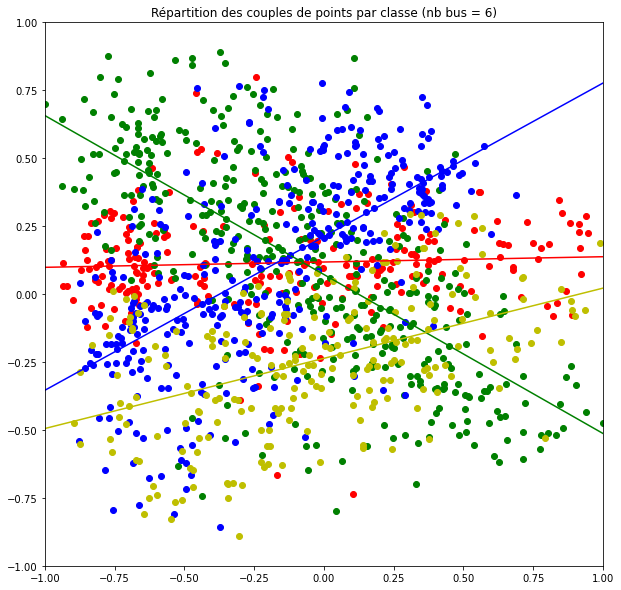

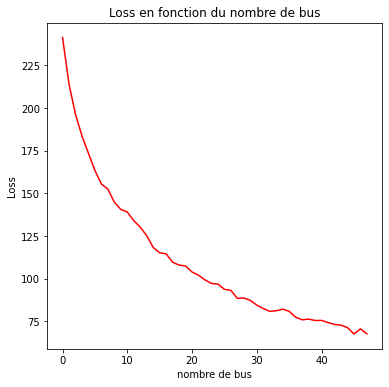

In [70]:
nb_bus = 50 # nombre de bus maximum
nb_iter = 10 # nombre d'itération pour faire converger mon algorithme "k-means"
nb_retry = 10 # nombre d'essais de l'algorithme
nb_trajet = gdf_np_sc.shape[0]
loss_stat=np.zeros(nb_bus)
best_cluster = np.zeros((nb_bus,nb_trajet))

# je run l'optimisation sur toutes les configurations entre 2 et nb_bus droites
for i in range(2,nb_bus):
    loss_min = 10000
    loss=np.zeros(nb_retry)
    cluster_save = np.zeros((nb_retry,nb_trajet))

    
    # je vais lancer la simulation plusieurs fois (nb_retry) et garder le meilleur résultat
    for l in range(nb_retry):
        line = np.zeros(((i+1),2))
        
        # initialisation des droites
        init_droite(i,line)

        dist_lines=np.zeros((nb_trajet,i+1))

        # boucle pour faire converger l algorithme
        for iter in range(nb_iter):
            # calcul de la distance de chaque couple de pointes aux droites du modele
            for k in range(i+1):
                dist_lines[:,k]=dist_trajet_line(line[k,0],line[k,1],
                                                 gdf_np_sc[:,0],
                                                 gdf_np_sc[:,1],
                                                 gdf_np_sc[:,2],
                                                 gdf_np_sc[:,3])
            
            # vecteur contenant pour chaque couple de droite la classe à laquelle il appartient
            cluster = np.argmin(dist_lines,axis=1)
            prev_line  = line[:,:]
            
            loss_rt = np.min(dist_lines,axis = 1).sum()

            # recalcul des droites du modele par regression lineaire des points de chacunes des classses
            for k in range(i+1):
                if (cluster ==k).sum() !=0:
                    point = gdf_np_sc[cluster == k,:].reshape(-1,2) 
                    x=point[:,0].reshape(-1,1)
                    y=point[:,1]
                    reg = LinearRegression().fit(x, y)
                    line[k,0]=reg.coef_
                    line[k,1]=reg.intercept_
                # si un des groupes est vide, une nouvelle droite est créée aléatoirement
                else:
                    r = random.random()*3.14
                    line[k,0]= math.sin(r)/math.cos(r)
                    p = random.random()*2.0-1.0
                    q = random.random()*1.2-0.6
                    line[k,1]= q-line[k,0]*p
                  
        loss[l] = loss_rt
        cluster_save[l] = cluster
                
    loss_min = loss.min()

    # Visualisation des droites et de l'affectation des couples aux classes pour 6 droites
    color = "rgbymk"
    if i == 3:
        plt.figure(figsize=(10, 10))
        for k in range(i+1):
            x = np.linspace(-1,1,100)
            y = prev_line[k,0]*x+prev_line[k,1]
            plt.plot(x, y, color[k%6], )
            plt.scatter(gdf_np_sc[cluster ==k,0],gdf_np_sc[cluster == k,1],c=color[k%6])
            plt.scatter(gdf_np_sc[cluster == k,2],gdf_np_sc[cluster == k,3],c=color[k%6])
        plt.xlim(-1,1)
        plt.ylim(-1, 1)
        plt.title("Répartition des couples de points par classe (nb bus = 6)")
        plt.show()
    
    best_cluster[i] = cluster_save[np.argmin(loss)]

    loss_stat[i]=loss_min

plt.figure(figsize=(6, 6))
plt.plot(loss_stat[2:], '-r')
plt.xlabel('nombre de bus')
plt.ylabel('Loss')
plt.title("Loss en fonction du nombre de bus")
plt.show()





**La Loss décroit rapidement jusqu'à environ 20, ensuite la décroissance est plus lente.**

Maintenant que j'ai des groupes de couple de point "homogènes" je vais pouvoir appliquer un algorythme TSP pour trouver les trajets effectifs réalisés par les bus.

# Algorithme TSP appliqué aux clusters définis précedement

J'ai utilisé un algorithme génétique présent dans la librairie scikit-opt

Comme, par construction, les couples sont dans un même cluster, dans cette partie, les couples de points de sont plus traités de manière particulière mais comme deux points indépendants.

Je ne souhaite pas forcément obtenir un trajet fermé comme habituellement pour les problèmes de TSP. J'ai donc ajouté un "point fictif" dans la table des distances avec une distance nulle entre ce point et les autres points du cluster.
Une fois le trajet optimal trouvé, j'enlève ce point fictif ce qui conduit à "ouvrir" le trajet

J'ai testé cet algorithme pour un nombre de bus allant de 10 à 45 et j'ai comparé les distances cumulées des trajets de bus (voir graph ci-dessous)

In [73]:
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sko.GA import GA_TSP

def call_total_distance(routine):
        num_points, = routine.shape
        return sum([distance_matrix[routine[i % num_points], routine[(i + 1) % num_points]] for i in range(num_points)])

min_bus = 10
max_bus = 45
color = "rgbymk"
graph= False
total_save=np.zeros(max_bus+1)
for k in range(min_bus,max_bus+1):
    total=0
    total_np = np.zeros(nb_bus)
    # je calcul pour chacun des clusters un TSP
    #plt.figure(figsize=(15, 15))

    for i in range(k):
        # selection des points du cluster en cours
        double_points = gdf_np_sc[best_cluster[k] == i,:]
        num_points = double_points.shape[0]*2

        # copie de tous les points des couples de points au même niveau
        points_coordinate = np.concatenate((double_points[:,0:2],double_points[:,2:4]),axis=0)

        # calcul de la matrice des distances
        init_matrix = spatial.distance.cdist(points_coordinate, points_coordinate, metric='euclidean')

        # ajout du point fictif et des distances à 0 en derniere ligne / derniere colonne
        num_points = double_points.shape[0]*2+1
        hor_zero=np.zeros(num_points).reshape(1,-1)
        ver_zero=np.zeros(num_points-1).reshape(-1,1)
        init2_matrix = np.concatenate((init_matrix,ver_zero),axis=1)
        distance_matrix = np.concatenate((init2_matrix,hor_zero),axis=0)

        # initialisation de l'algorithme génétique TSP
        ga_tsp = GA_TSP(func=call_total_distance, n_dim=num_points, size_pop=50, max_iter=500, prob_mut=0.5)

        # calcul des trajets et des distances
        best_points, best_distance = ga_tsp.run()

        # suppression du point fictif de la liste des points pour ouvrir le trajet
        best_points_ = np.roll(best_points,-np.argmax(best_points))[1:]

        # récupération des coordonnées des points du trajet
        best_points_coordinate = points_coordinate[best_points_, :]

        # impression des trajets
        if graph:
            plt.subplot(5, 5, i+1)
            plt.plot(best_points_coordinate[:, 1], best_points_coordinate[:, 0], color[i % 6] )
            plt.xlim(-1,1)
            plt.ylim(-1, 1)
        total = total+ga_tsp.generation_best_Y[-1]
    plt.show()
    total_save[k]=total
    print(k,total)

# Pour limiter les calculs je vais tester les clusters générés par un nombre de bus entre 10 et 45


10 138.58063314671568
11 139.4124258873112
12 136.40475594871967
13 137.8499470306841
14 129.78697116510466
15 120.40227699256974
16 115.15097865736666
17 112.02643866611108
18 114.80492821295114
19 104.97994695147068
20 115.06748747435216
21 116.40826408729752
22 113.7362666824009
23 113.64205028115559
24 110.77106925730499
25 115.27246812335923
26 113.57850836604922
27 114.1655755978987
28 110.68976689484249
29 112.43537568044975
30 111.52961607045985
31 115.15010519138507
32 112.8254626188121
33 112.0173934426179
34 113.2286833107501
35 112.85835126148778
36 118.41836456725144
37 116.60475080075403
38 114.1493263166189
39 116.50700061287361
40 116.79616040257709
41 120.67172185882272
42 119.59138083743511
43 123.11323546233452
44 117.95337597801199
45 120.75302936950496


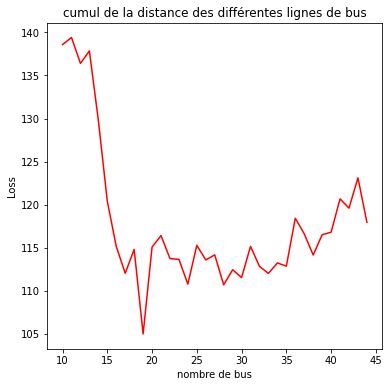

In [74]:
plt.figure(figsize=(6, 6))
plt.plot(range(10,45),total_save[10:45], '-r')
plt.xlabel('nombre de bus')
plt.ylabel('Loss')
plt.title("cumul de la distance des différentes lignes de bus")
plt.show()

**Le loss semble le plus bas entre 15 et 30 lignes de bus**

**Pour Finir, je garde le minimum relatif trouvé pour les 19 lignes de bus (je n'ai pas gardé la solution à 16 lignes car cela génère un nombre importnat d'arrêts). Je représente ci dessous graphiquement l'ensemble des trajets de ces lignes de bus**

**Je sauvegarde également le résultat dans un fichier joint : OD_proposition.csv dans le même ordre de points que le fichier source**

1) coordonnées longitude / lattidude des couples de points (dans le même ordre que dans le fichier d'origine)  
2) num_bus : numéro du bus  
3) ordre point_1 : séquence du point 1 sur la ligne  
4) ordre point_2 : séquence du point 2 sur la ligne

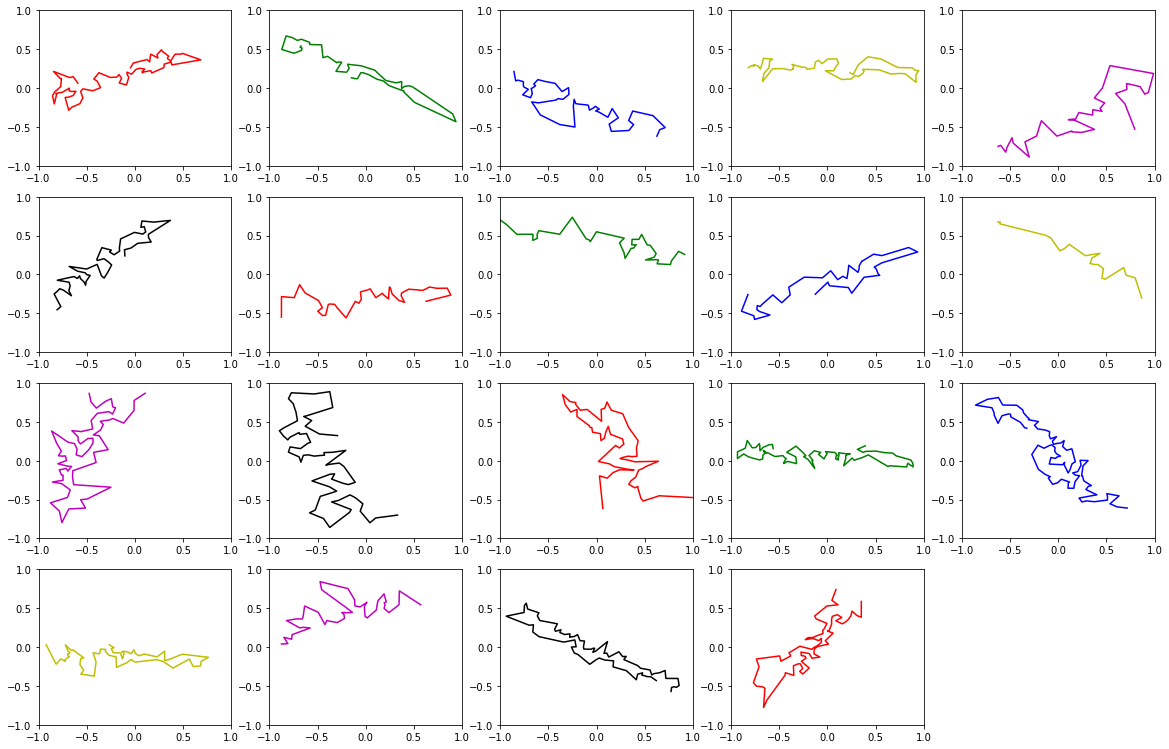

19 98.49938473028752


In [75]:
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sko.GA import GA_TSP

def call_total_distance(routine):
        num_points, = routine.shape
        return sum([distance_matrix[routine[i % num_points], routine[(i + 1) % num_points]] for i in range(num_points)])


color = "rgbymk"
min_bus = 19
max_bus = 19
graph = True
file = True
file_save=np.zeros((nb_trajet,3))
total_save=np.zeros(max_bus+1)
index = np.arange(nb_trajet)
for k in range(min_bus,max_bus+1):
    total=0
    total_np = np.zeros(nb_bus)
    
    # je calcul pour chacun des clusters un TSP
    plt.figure(figsize=(20, 20))
    for i in range(k):
        # selection des points du cluster en cours
        double_points = gdf_np_sc[best_cluster[k] == i,:]
        num_points = double_points.shape[0]*2
        # copie de tous les points des couples de points au même niveau
        points_coordinate = np.concatenate((double_points[:,0:2],double_points[:,2:4]),axis=0)

        # calcul de la matrice des distances
        init_matrix = spatial.distance.cdist(points_coordinate, points_coordinate, metric='euclidean')

        # ajout du point fictif et des distances à 0 en derniere ligne / derniere colonne
        num_points = double_points.shape[0]*2+1
        hor_zero=np.zeros(num_points).reshape(1,-1)
        ver_zero=np.zeros(num_points-1).reshape(-1,1)
        init2_matrix = np.concatenate((init_matrix,ver_zero),axis=1)
        distance_matrix = np.concatenate((init2_matrix,hor_zero),axis=0)

        # initialisation de l'algorithme génétique TSP
        ga_tsp = GA_TSP(func=call_total_distance, n_dim=num_points, size_pop=200, max_iter=1000, prob_mut=0.5)

        # calcul des trajets et des distances
        best_points, best_distance = ga_tsp.run()
        # suppression du point fictif de la liste des points pour ouvrir le trajet
        best_points_ = np.roll(best_points,-np.argmax(best_points))[1:]

        # récupération des coordonnées des points du trajet
        best_points_coordinate = points_coordinate[best_points_, :]

        # impression des trajets
        if graph:
            plt.subplot(6, 5, i+1)
            plt.plot(best_points_coordinate[:, 0], best_points_coordinate[:, 1], color[i % 6] )
            plt.xlim(-1,1)
            plt.ylim(-1, 1)
        if file:            
            for j in range(best_points_.shape[0]):
                index_num = best_points_[j]
                if index_num >= int(best_points_.shape[0] / 2):
                    file_save[index[best_cluster[k]==i][best_points_[j]%int(best_points_.shape[0] / 2)],0]=i
                    file_save[index[best_cluster[k]==i][best_points_[j]%int(best_points_.shape[0] / 2)],2]=j
                else:
                    file_save[index[best_cluster[k]==i][best_points_[j]%int(best_points_.shape[0] / 2)],0]=i
                    file_save[index[best_cluster[k]==i][best_points_[j]%int(best_points_.shape[0] / 2)],1]=j

        total = total+ga_tsp.generation_best_Y[-1]
    plt.show()
    total_save[k]=total
    print(k,total)
    np.savetxt("OD_proposition.csv",np.concatenate((coord_geo_np,file_save),axis=1),header='lon point_1;lat point_1;lon point_2;lat point_2;num_bus;ordre point_1;ordre point_2', fmt=['%10.7f','%10.7f','%10.7f','%10.7f','%d','%d','%d'],delimiter=';')
